### Starting Imports, Setting Device, Etc

In [1]:
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
import os as os
import copy

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA :)")
else:
    device = torch.device("cpu")
    print("Using CPU :(")

Using CUDA :)


### Defining Data

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
# Dataset class

class simpleDataset(Dataset):
    def __init__(self, inputPaths, outputPaths):

        names = copy.deepcopy(inputPaths)
        for i in range(len(names)):
            temp = names[i]
            names[i] = temp[:-3]

        self.names = names
        self.input_paths = inputPaths
        self.output_paths = outputPaths

    def __len__(self):
        return(len(self.input_paths))

    def __getitem__(self, index):
        x = torch.load(self.input_paths[index])
        y = torch.load(self.output_paths[index])
        return x, y

    def __getitemFromName__(self, name):
        for item in self.input_paths:
            if item.endswith(name + ".pt"):
                x = torch.load(item)
        for item in self.output_paths:
            if item.endswith(name + "_output.pt"):
                y = torch.load(item)
                y = y.view(91)
        return x, y

    def __getitemName__(self, index):
        return self.names[0]

In [5]:
# Training dataset

trainInpPaths = list(map(lambda x: os.path.join(os.path.abspath('trainInput'), x),os.listdir('trainInput')))
trainInpPaths.sort()
for i in trainInpPaths:
    if i.endswith(".pt") != True:
        trainInpPaths.remove(i)

trainOutPaths = list(map(lambda x: os.path.join(os.path.abspath('trainOutput'), x),os.listdir('trainOutput')))
trainOutPaths.sort()
for i in trainOutPaths:
    if i.endswith(".pt") != True:
        trainOutPaths.remove(i)

train_data = simpleDataset(trainInpPaths, trainOutPaths)

In [6]:
# Validation dataset

validInpPaths = list(map(lambda x: os.path.join(os.path.abspath('validationInput'), x),os.listdir('validationInput')))
validInpPaths.sort()
for i in validInpPaths:
    if i.endswith(".pt") != True:
        validInpPath.remove(i)

validOutPaths = list(map(lambda x: os.path.join(os.path.abspath('validationOutput'), x),os.listdir('validationOutput')))
validOutPaths.sort()
for i in validOutPaths:
    if i.endswith(".pt") != True:
        validOutPaths.remove(i)

valid_data = simpleDataset(validInpPaths, validOutPaths)

In [7]:
# Test dataset

testInpPaths = list(map(lambda x: os.path.join(os.path.abspath('testInput'), x),os.listdir('testInput')))
testInpPaths.sort()
for i in testInpPaths:
    if i.endswith(".pt") != True:
        testInpPaths.remove(i)

testOutPaths = list(map(lambda x: os.path.join(os.path.abspath('testOutput'), x),os.listdir('testOutput')))
testOutPaths.sort()
for i in testOutPaths:
    if i.endswith(".pt") != True:
        testOutPaths.remove(i)

test_data = simpleDataset(testInpPaths, testOutPaths)

### Defining Model

In [8]:
from torch import nn
import torch.nn.functional as f

In [22]:
# The Model(s)

class simpleNet_3sig(torch.nn.Module):
    def __init__(self):
        super(simpleNet_3sig, self).__init__()
        torch.manual_seed(501)
        
        self.fc1 = nn.Linear(220_000, 360)
        self.fc2 = nn.Linear(360, 180)
        self.fc3 = nn.Linear(180, 72)

    def forward(self, x):
        x = x.view(batch_size, -1)
        
        x = f.sigmoid(self.fc1(x))
        x = f.sigmoid(self.fc2(x))
        x = f.sigmoid(self.fc3(x))
        x = x.view(-1, 6, 12)
        return x

class simpleNet_2sig(torch.nn.Module):
    def __init__(self):
        super(simpleNet_2sig, self).__init__()
        torch.manual_seed(501)
        
        self.fc1 = nn.Linear(220_000, 360)
        self.fc2 = nn.Linear(360, 180)
        self.fc3 = nn.Linear(180, 72)

    def forward(self, x):
        x = x.view(batch_size, -1)
        
        x = f.relu(self.fc1(x))
        x = f.sigmoid(self.fc2(x))
        x = f.sigmoid(self.fc3(x))
        x = x.view(-1, 6, 12)
        return x

class simpleNet_1sig(torch.nn.Module):
    def __init__(self):
        super(simpleNet_1sig, self).__init__()
        torch.manual_seed(501)
        
        self.fc1 = nn.Linear(220_000, 360)
        self.fc2 = nn.Linear(360, 180)
        self.fc3 = nn.Linear(180, 72)

    def forward(self, x):
        x = x.view(batch_size, -1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = f.sigmoid(self.fc3(x))
        x = x.view(-1, 6, 12)
        return x

In [9]:
### Hyperparameters
n_epochs = 5   # number of epochs to run
batch_size = 1  # size of each batch

### Training Model

In [10]:
### Loading Batches
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle = True)

In [23]:
sig_tests = [1]
lr = [0.001]
#sig_tests = [1, 2, 3]
#lr = [0.01,0.005,0.001]

for cur_sig in sig_tests:
    for cur_lr in lr:
        print("\n")
        print(f"Testing learning rate {cur_lr} with {cur_sig} sigmoids.")

        if cur_sig == 3:
            model = simpleNet_3sig()
        elif cur_sig == 2:
            model = simpleNet_2sig()
        elif cur_sig == 1:
            model = simpleNet_1sig()
        model.double()
        model.to(device)

        loss_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=cur_lr)

        training_loss = list()

        n_steps = len(train_loader)
        for epoch in range(n_epochs):
            for i, (pdbInp, realOut) in enumerate(train_loader):
                pdbInp = pdbInp.to(device)
                realOut = realOut.to(device)

                trainOut = model(pdbInp)
                loss = loss_fn(trainOut, realOut)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                if (i+1) % 490 == 0:
                    print(f"Epoch: {epoch+1}/{n_epochs} ; Step {i+1}/{n_steps} ; Loss: {loss.item():.4f}")
            training_loss.append(loss.item())

        valRunLoss = 0
        for i, (pdbInp, realOut) in enumerate(valid_loader):
                pdbInp = pdbInp.to(device)
                realOut = realOut.to(device)

                validOut = model(pdbInp)
                curLoss = loss_fn(validOut, realOut)
                valRunLoss += curLoss

        avgVLoss = valRunLoss / len(valid_loader)
        print(f"The average validation loss is {avgVLoss:.4f}")
        print("\n")
print("Finished!")



Testing learning rate 0.001 with 1 sigmoids.
Epoch: 1/5 ; Step 490/490 ; Loss: 0.2687
Epoch: 2/5 ; Step 490/490 ; Loss: 0.2738
Epoch: 3/5 ; Step 490/490 ; Loss: 0.3396
Epoch: 4/5 ; Step 490/490 ; Loss: 0.3277
Epoch: 5/5 ; Step 490/490 ; Loss: 0.3259
The average validation loss is 0.3120


Finished!


In [16]:
tri_sig_high_rate = [0.0182, 0.0082, 0.0160, 0.0111, 0.0081]
tri_sig_med_rate = [0.0149, 0.0080, 0.0166, 0.0122, 0.0085]
tri_sig_low_rate = [0.0088, 0.0066, 0.0159, 0.0143, 0.0106]
bi_sig_high_rate = [0.0202, 0.0082, 0.0128, 0.0104, 0.0195]
bi_sig_med_rate = [0.0188, 0.0085, 0.0117, 0.0077, 0.0081]
bi_sig_low_rate = [0.0089, 0.0071, 0.0150, 0.0191, 0.0097]
mono_sig_high_rate = [0.2764, 0.3044, 0.3644, 0.3588, 0.3222]
mono_sig_med_rate = [0.2745, 0.2984, 0.3624, 0.3567, 0.3209]
mono_sig_low_rate = [0.2687, 0.2738, 0.3396, 0.3277, 0.3259]

tri_sig_high_rate_valid = 0.0192
tri_sig_med_rate_valid = 0.0192
tri_sig_low_rate_valid = 0.0192
bi_sig_high_rate_valid = 0.0392
bi_sig_med_rate_valid = 0.0223
bi_sig_low_rate_valid = 0.0189 
mono_sig_high_rate_valid = 0.3183
mono_sig_med_rate_valid = 0.3165
mono_sig_low_rate_valid = 0.3120

In [17]:
testRunLoss = 0
for i, (pdbInp, realOut) in enumerate(test_loader):
        pdbInp = pdbInp.to(device)
        realOut = realOut.to(device)

        testOut = model(pdbInp)
        curLoss = loss_fn(testOut, realOut)
        testRunLoss += curLoss

avgTLoss = testRunLoss / len(test_loader)
print(f"The average MSE of the testing dataset is {avgTLoss}")

The average MSE of the testing dataset is 0.012568671968206048


### Model Analysis Figures

Tri_sig is three sigmoids; bi_sig is two sigmoids, one ReLu; MonoSig is one sigmoid, two ReLu.

High rate is 0.01; med rate is 0.005; low rate is 0.001

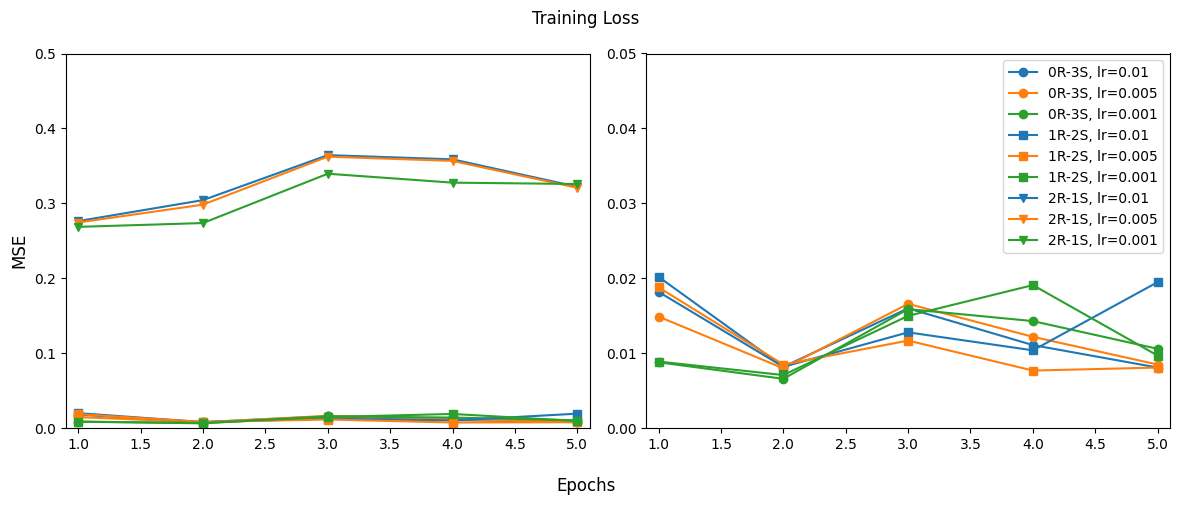

In [18]:
epoch_array = np.arange(1, 6)

fig, (ax1, ax2) = plt.subplots(1,2, tight_layout = True, figsize = (12,5))

ax1.plot(epoch_array, tri_sig_high_rate, color = "C0", marker = "o")
ax1.plot(epoch_array, tri_sig_med_rate, color = "C1", marker = "o")
ax1.plot(epoch_array, tri_sig_low_rate, color = "C2", marker = "o")
ax1.plot(epoch_array, bi_sig_high_rate, color = "C0", marker = "s")
ax1.plot(epoch_array, bi_sig_med_rate, color = "C1", marker = "s")
ax1.plot(epoch_array, bi_sig_low_rate, color = "C2", marker = "s")
ax1.plot(epoch_array, mono_sig_high_rate, color = "C0", marker = "v")
ax1.plot(epoch_array, mono_sig_med_rate, color = "C1", marker = "v")
ax1.plot(epoch_array, mono_sig_low_rate, color = "C2", marker = "v")

ax1.set_xlim(0.9, 5.1)
ax1.set_ylim(0, 0.5)

ax2.plot(epoch_array, tri_sig_high_rate, color = "C0", marker = "o", label = "0R-3S, lr=0.01")
ax2.plot(epoch_array, tri_sig_med_rate, color = "C1", marker = "o", label = "0R-3S, lr=0.005")
ax2.plot(epoch_array, tri_sig_low_rate, color = "C2", marker = "o", label = "0R-3S, lr=0.001")
ax2.plot(epoch_array, bi_sig_high_rate, color = "C0", marker = "s", label = "1R-2S, lr=0.01")
ax2.plot(epoch_array, bi_sig_med_rate, color = "C1", marker = "s", label = "1R-2S, lr=0.005")
ax2.plot(epoch_array, bi_sig_low_rate, color = "C2", marker = "s", label = "1R-2S, lr=0.001")
ax2.plot(epoch_array, mono_sig_high_rate, color = "C0", marker = "v", label = "2R-1S, lr=0.01")
ax2.plot(epoch_array, mono_sig_med_rate, color = "C1", marker = "v", label = "2R-1S, lr=0.005")
ax2.plot(epoch_array, mono_sig_low_rate, color = "C2", marker = "v", label = "2R-1S, lr=0.001")

ax2.set_xlim(0.9, 5.1)
ax2.set_ylim(0, 0.05)

ax2.legend(bbox_to_anchor = (1,1))

fig.supxlabel("Epochs")
fig.supylabel("MSE")
fig.suptitle("Training Loss")

#plt.savefig("modelTrainingLoss.png", dpi=400)
plt.show()

# Creating Test PPI Maps

In [11]:
import matplotlib.cm as cm

In [12]:
def ppi_map_model_compare(modelScores, realScores, title, cmap):
    fig, axes = plt.subplots(1, 2, dpi = 400, figsize = (12,4), layout = "compressed")
    fig.suptitle(f"{title}", x = 0.475, horizontalalignment = "center")
    fig.supylabel("\u03B8\u00B0")
    fig.supxlabel("\u03C6\u00B0", x = 0.475, horizontalalignment = "center")
    
    axes[0].imshow(modelScores, cmap = cmap, vmin = 0, vmax = 1, origin = "lower", extent = [0, 360, 0, 180])
    axes[0].set_xticks(np.arange(0, 400, 50))
    axes[0].set_yticks(np.arange(0, 200, 20))
    axes[0].set_title("ML Model")
    
    axes[1].imshow(realScores, cmap = cmap, vmin = 0, vmax = 1, origin = "lower", extent = [0, 360, 0, 180])
    axes[1].set_xticks(np.arange(0, 400, 50))
    axes[1].set_yticks(np.arange(0, 200, 20))
    axes[1].set_title("Real Map")

    m = plt.cm.ScalarMappable(cmap=cm.jet)
    m.set_clim(0, 1)
    axpos = axes[1].get_position()
    cax = axes[1].inset_axes([axpos.x1+0.15,axpos.y0 - 0.23,0.04,1.9*axpos.height])
    map_2_cbar = plt.colorbar(m, cax = cax, label = "Normalized Score")
    map_2_cbar.ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

    return

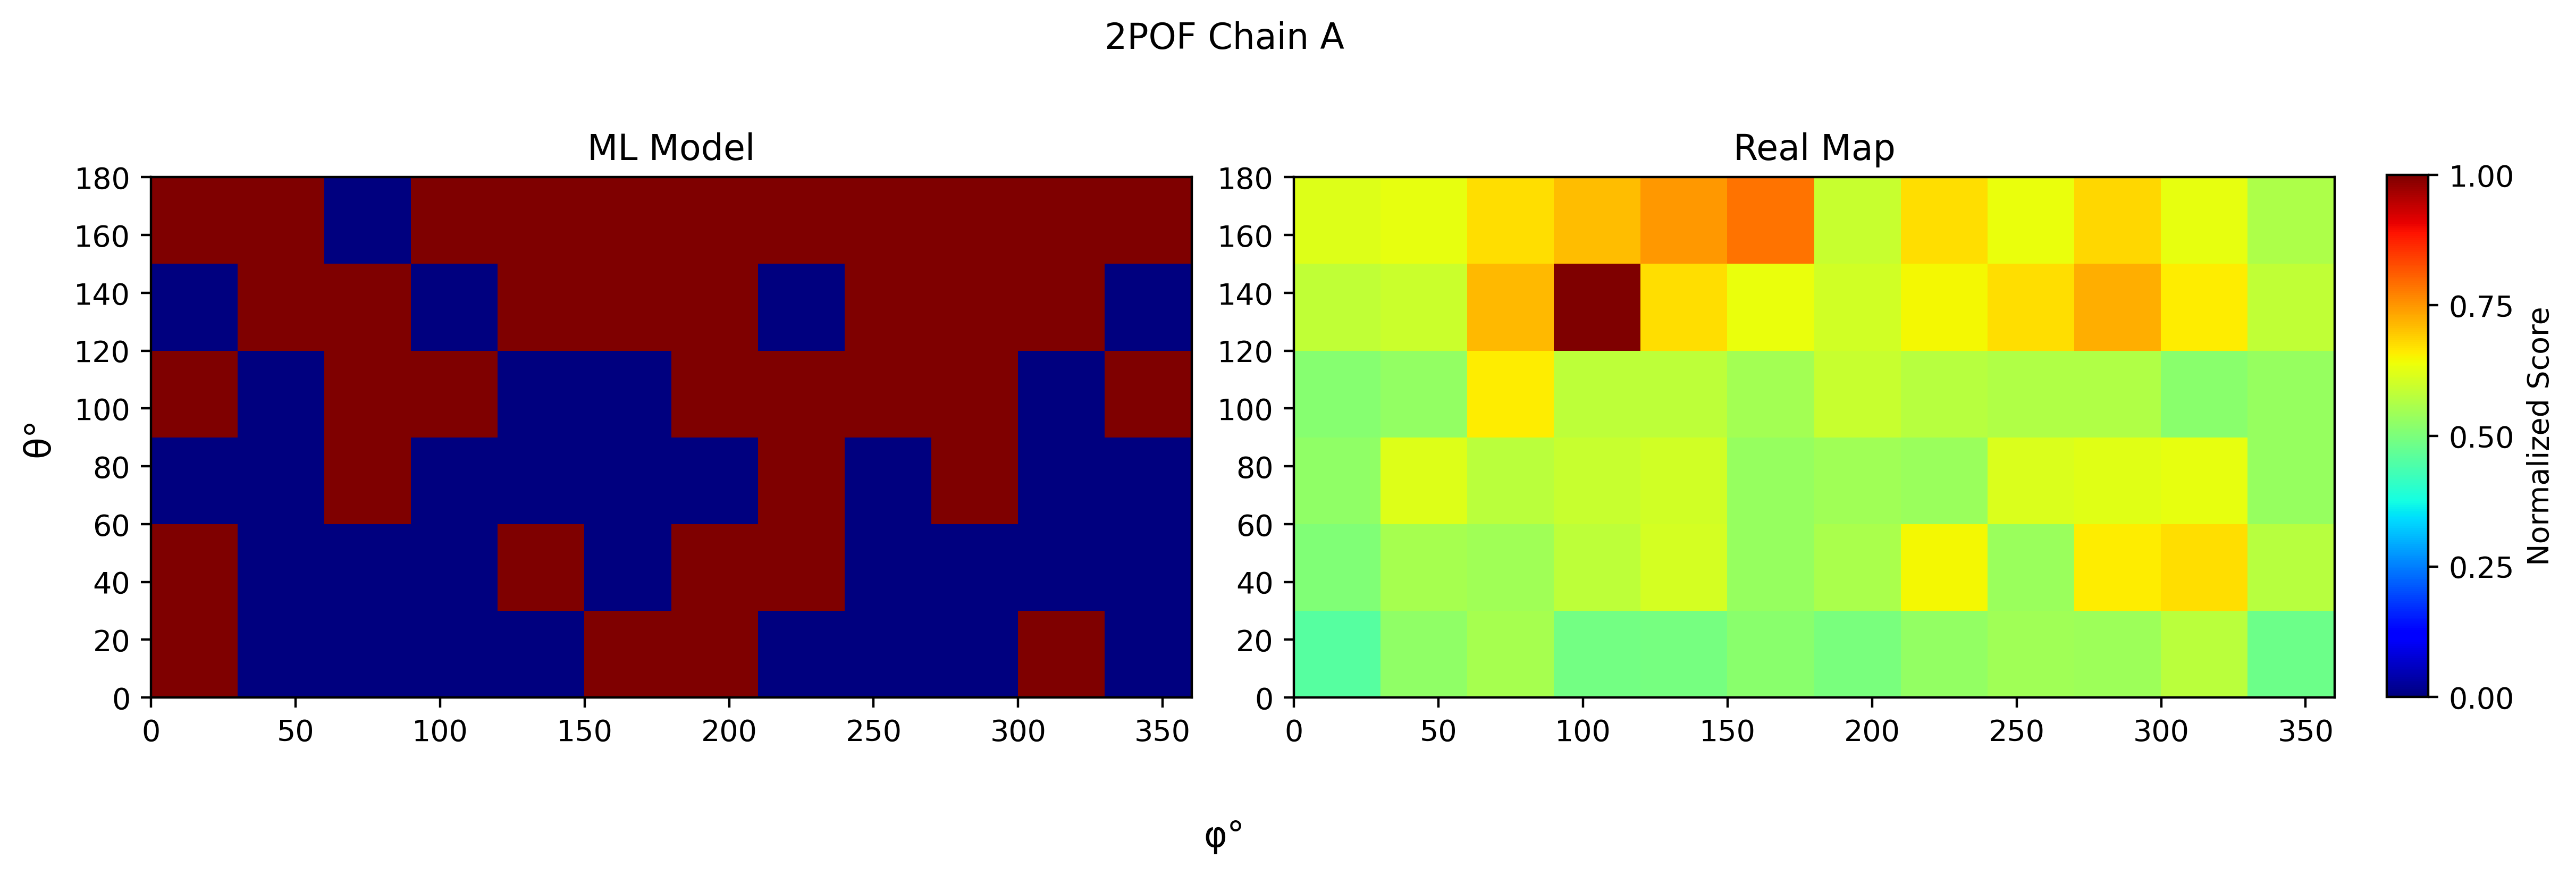

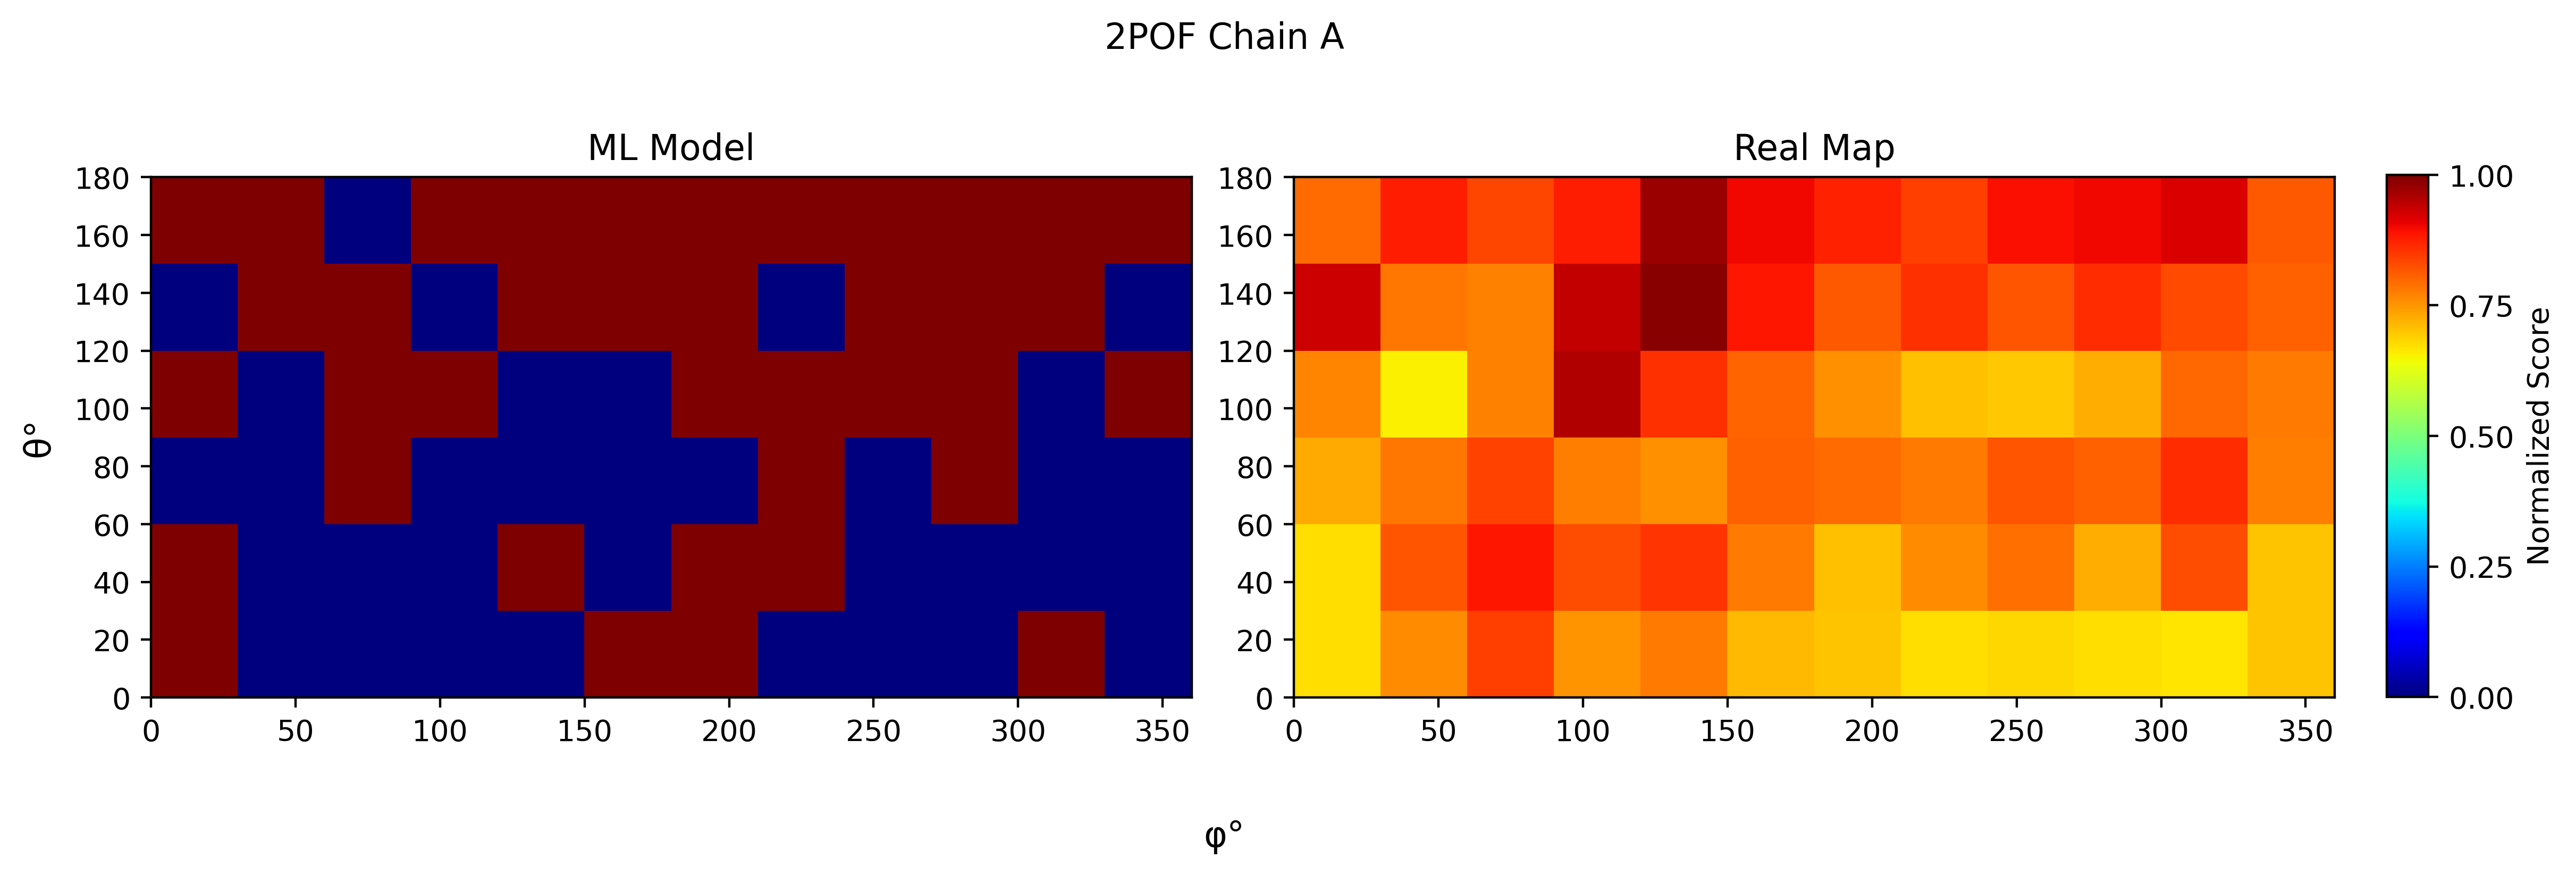

In [25]:
name = "d1jg8d_"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
plt.savefig(f"{name}_ML_mse_1sig.png", dpi = 400)
plt.show()

name = "d3pmga4"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
plt.savefig(f"{name}_ML_mse_1sig.png", dpi = 400)
plt.show()

# JS Divergence Loss

In [13]:
def js_loss(trainingData, realData):
    
    trainingData = trainingData[realData !=0]
    realData = realData[realData !=0]
    realData = realData[trainingData !=0]
    trainingData = trainingData[trainingData !=0]
    
    trainingData = trainingData / torch.sum(trainingData)
    realData = realData / torch.sum(realData)
    mixture = trainingData + realData
    mixture = mixture / 2
    
    js = torch.sum( trainingData * torch.log(trainingData / mixture) )
    js += torch.sum( realData * torch.log(realData / mixture) )
    return js

In [47]:
lr = [0.01, 0.005, 0.001]
n_epochs=5

for cur_lr in lr:
    print("\n")
    print(f"Testing learning rate {cur_lr} with 3 sigmoids.")

    model = simpleNet_3sig()
    model.double()
    model.to(device)

    loss_fn = js_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=cur_lr)

    training_loss = list()

    n_steps = len(train_loader)
    for epoch in range(n_epochs):
        for i, (pdbInp, realOut) in enumerate(train_loader):
            pdbInp = pdbInp.to(device)
            realOut = realOut.to(device)

            trainOut = model(pdbInp)
            loss = loss_fn(trainOut, realOut)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            if (i+1) % 490 == 0:
                print(f"Epoch: {epoch+1}/{n_epochs} ; Step {i+1}/{n_steps} ; Loss: {loss.item():.6f}")
        training_loss.append(loss.item())

    valRunLoss = 0
    for i, (pdbInp, realOut) in enumerate(valid_loader):
            pdbInp = pdbInp.to(device)
            realOut = realOut.to(device)

            validOut = model(pdbInp)
            curLoss = loss_fn(validOut, realOut)
            valRunLoss += curLoss

    avgVLoss = valRunLoss / len(valid_loader)
    print(f"The average validation loss is {avgVLoss:.6f}")
    print("\n")
print("Finished!")



Testing learning rate 0.01 with 3 sigmoids.


KeyboardInterrupt: 

In [15]:
tri_sig_high_rate = [0.004050, 0.002369, 0.001919, 0.002230, 0.002644]
tri_sig_med_rate = [0.004074, 0.002375, 0.001919, 0.002230, 0.002643]
tri_sig_low_rate = [0.003968, 0.002509, 0.001928, 0.002128, 0.002407]

tri_sig_high_rate_valid = 0.004085
tri_sig_med_rate_valid = 0.004085
tri_sig_low_rate_valid = 0.004037

In [43]:
testRunLoss = 0
for i, (pdbInp, realOut) in enumerate(test_loader):
        pdbInp = pdbInp.to(device)
        realOut = realOut.to(device)

        testOut = model(pdbInp)
        curLoss = loss_fn(testOut, realOut)
        testRunLoss += curLoss

avgTLoss = testRunLoss / len(test_loader)
print(f"The average MSE of the testing dataset is {avgTLoss}")

The average MSE of the testing dataset is 0.0030428217275637096


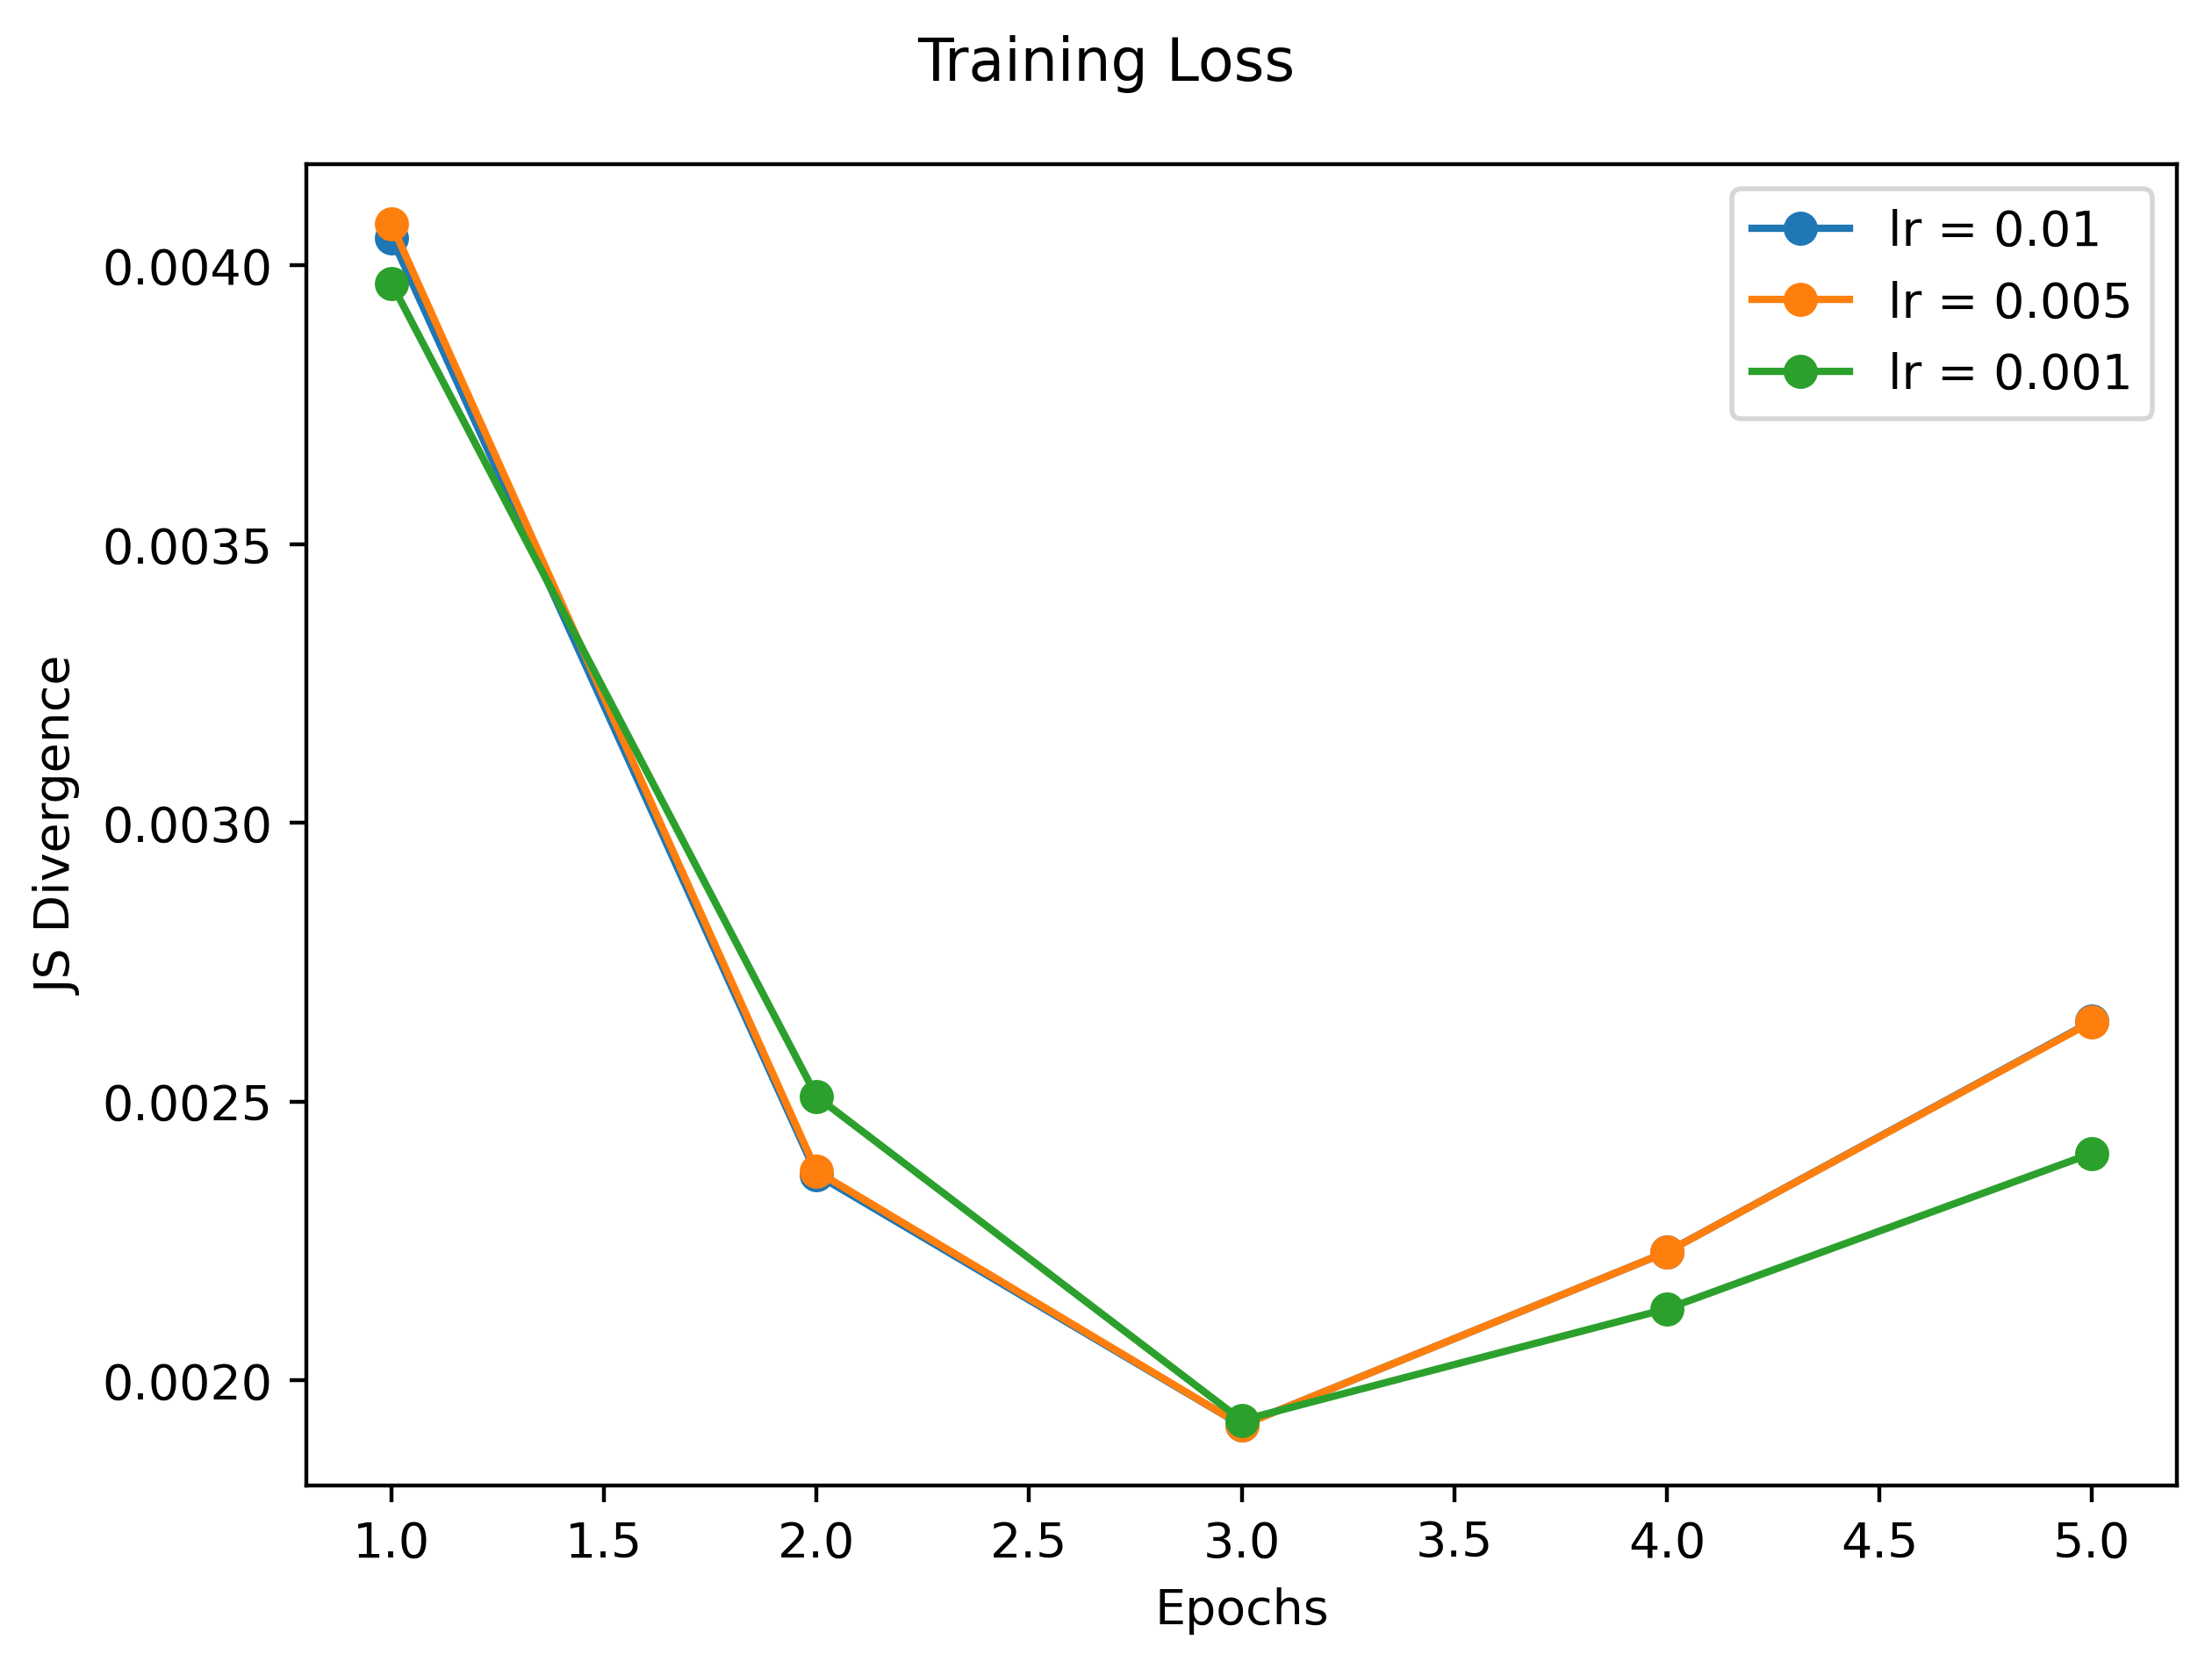

In [22]:
epoch_array = np.arange(1, 6)

fig, ax1 = plt.subplots(1,1, tight_layout = True, dpi = 400)

ax1.plot(epoch_array, tri_sig_high_rate, color = "C0", marker = "o", label = "lr = 0.01")
ax1.plot(epoch_array, tri_sig_med_rate, color = "C1", marker = "o", label = "lr = 0.005")
ax1.plot(epoch_array, tri_sig_low_rate, color = "C2", marker = "o", label = "lr = 0.001")

#ax1.set_xlim(0.9, 5.1)
#ax1.set_ylim(0, 0.5)

ax1.legend()

ax1.set_xlabel("Epochs")
ax1.set_ylabel("JS Divergence")
fig.suptitle("Training Loss")

#plt.savefig("jsTrainingLoss.png", dpi=400)
plt.show()

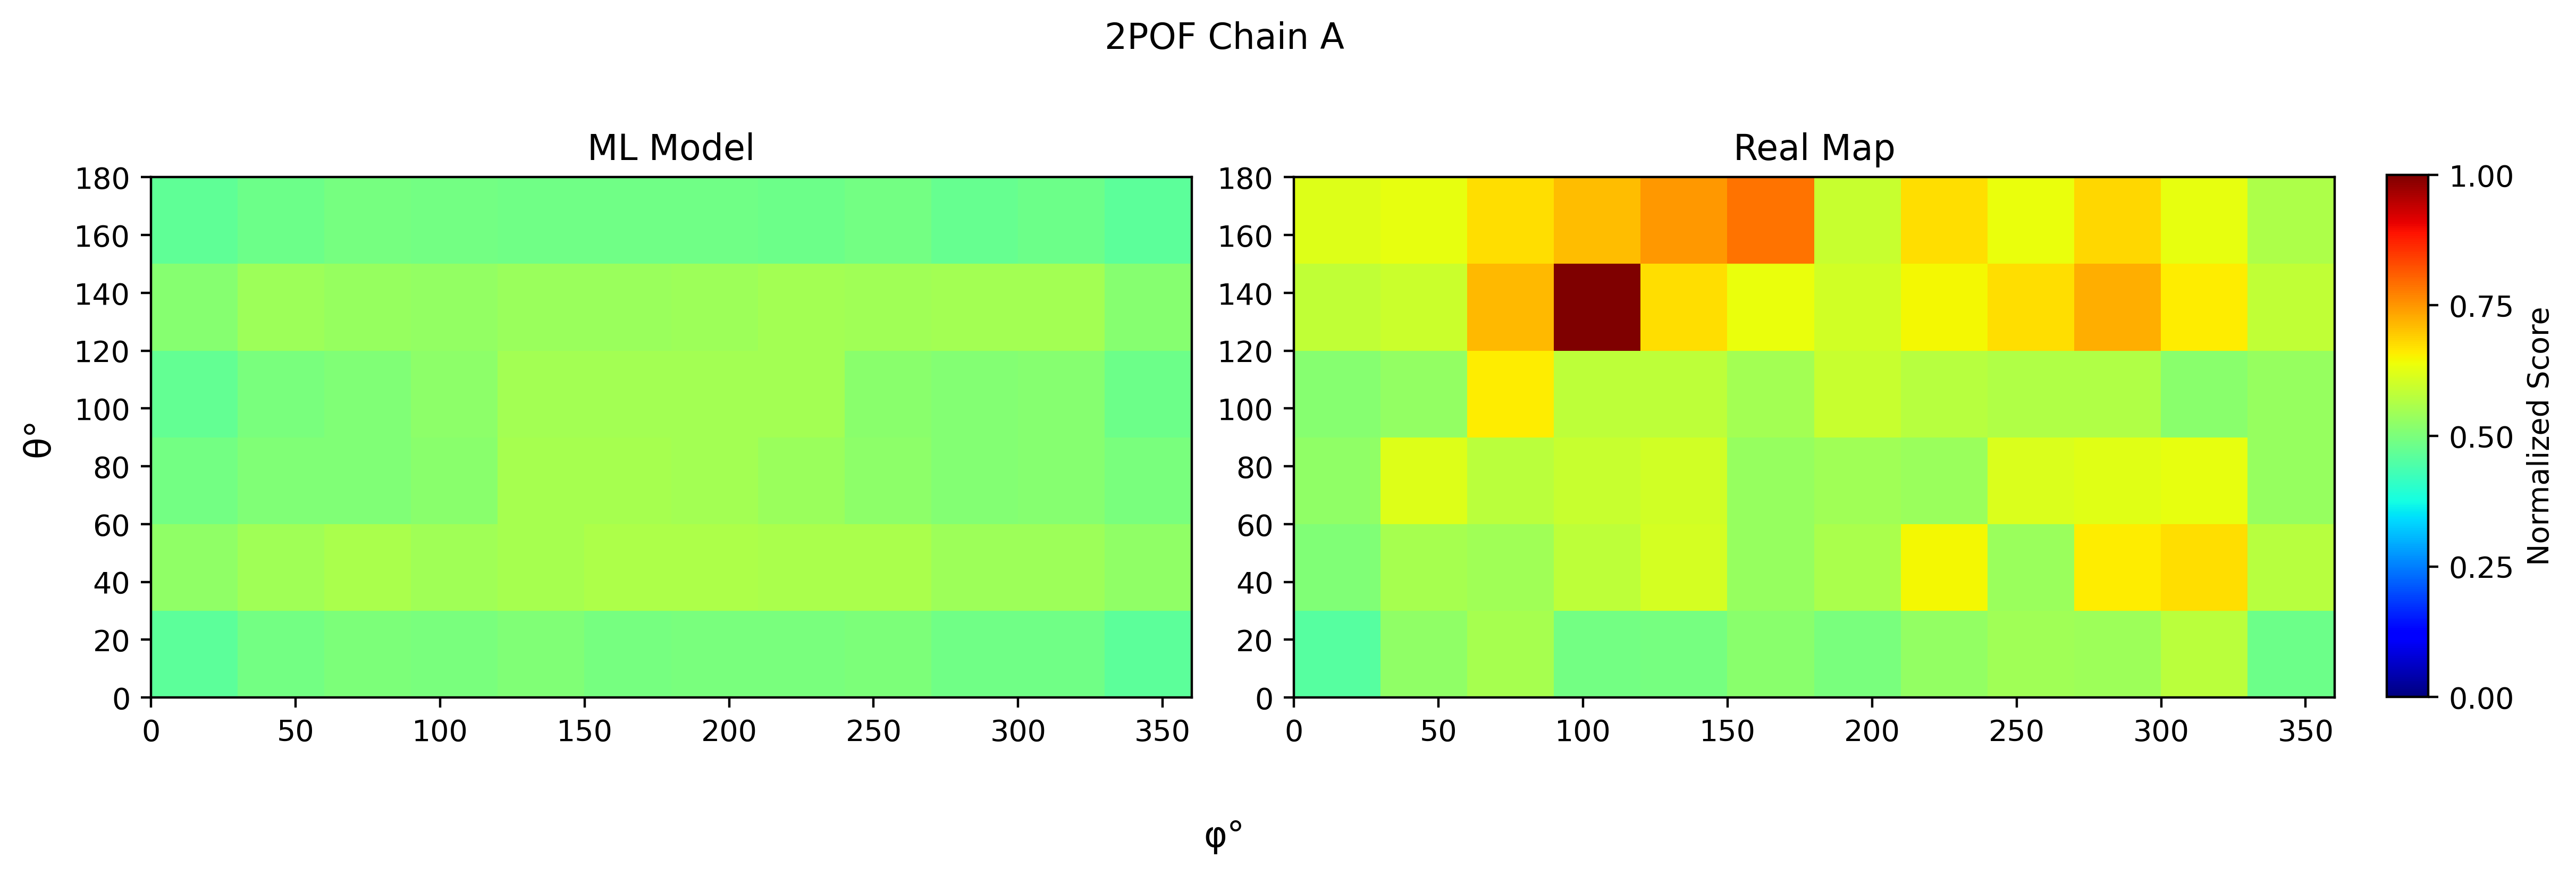

In [44]:
name = "d1jg8d_"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
#plt.savefig(f"{name}_ML_js.png", dpi = 400)
plt.show()

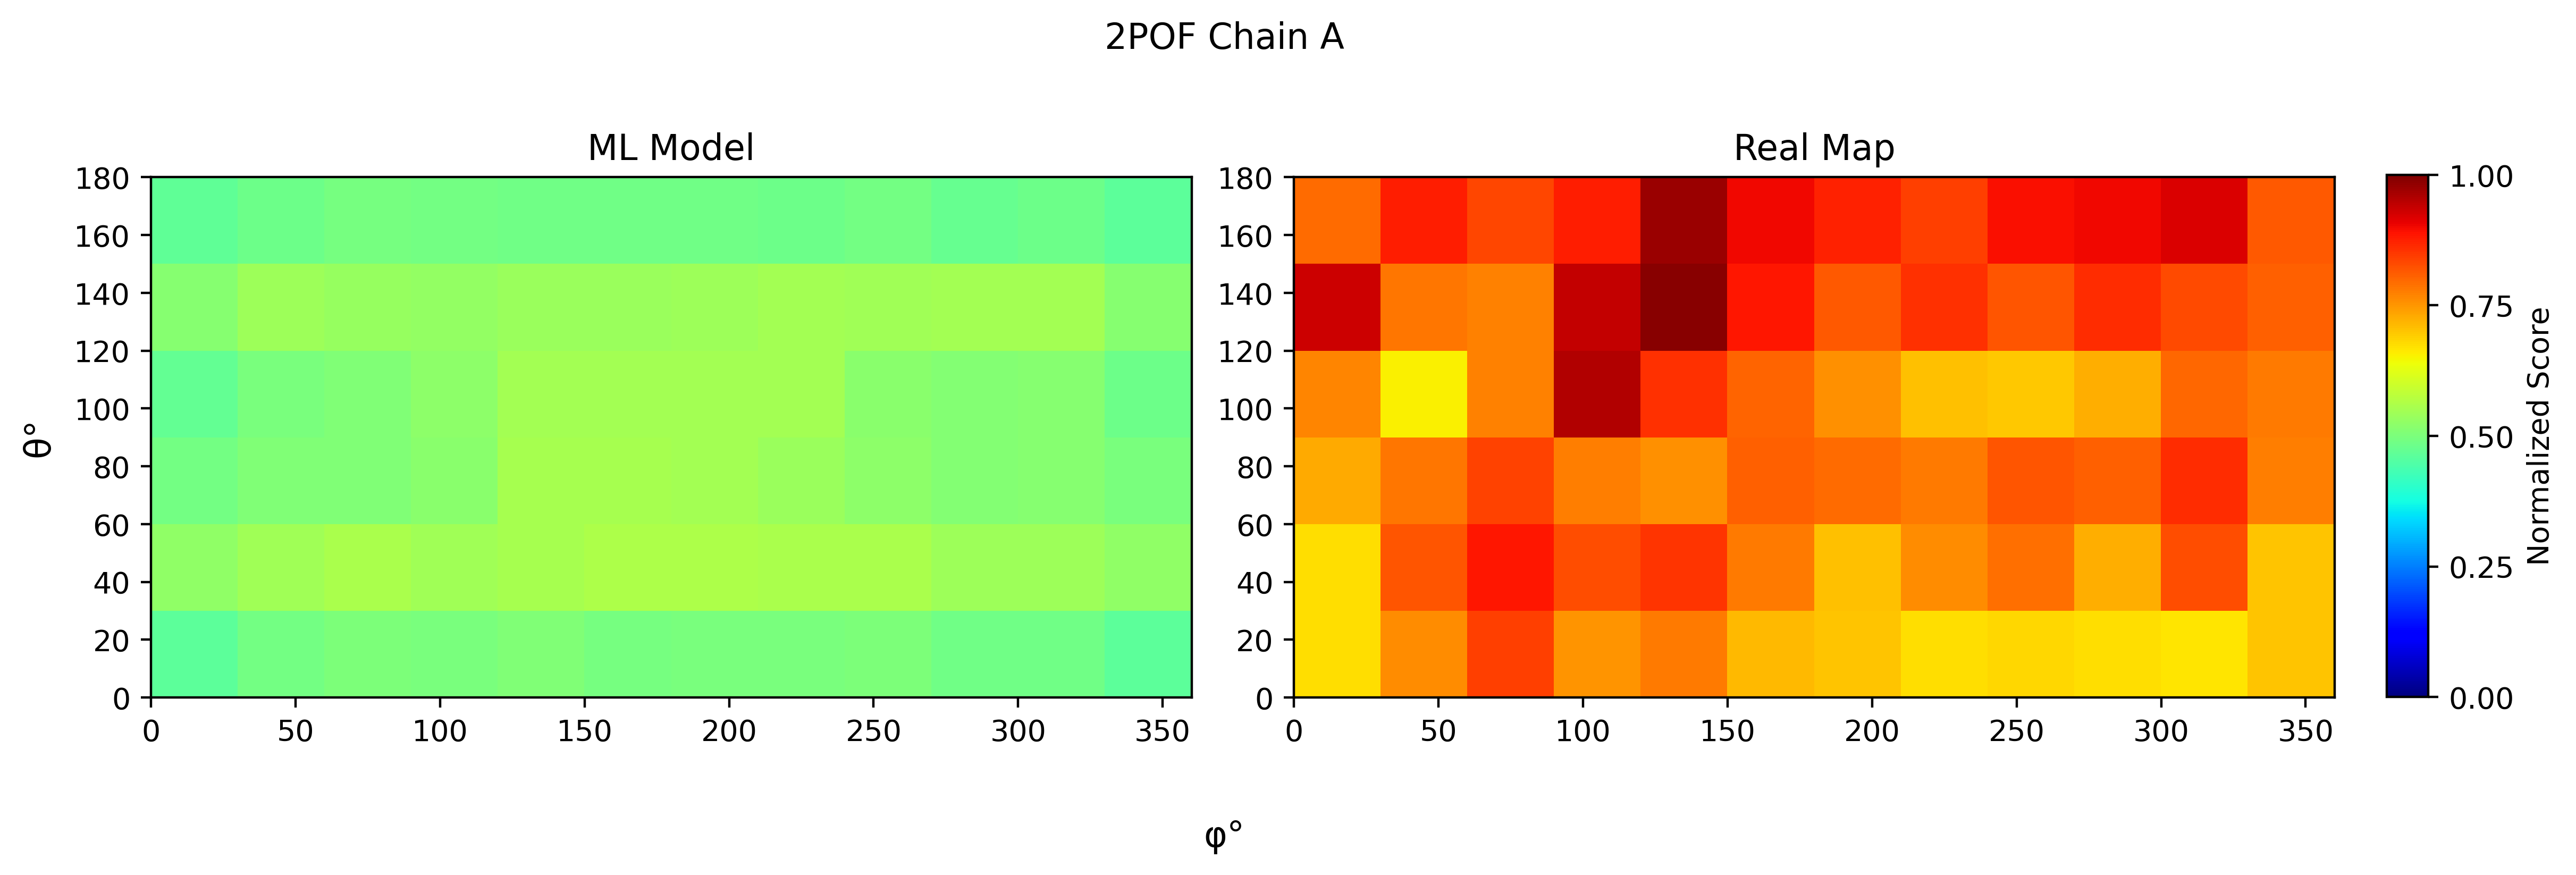

In [45]:
name = "d3pmga4"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
#plt.savefig(f"{name}_ML_js.png", dpi = 400)
plt.show()

# Increase Model Size

In [15]:
class simpleNet_3sig_large(torch.nn.Module):
    def __init__(self):
        super(simpleNet_3sig_large, self).__init__()
        torch.manual_seed(501)
        
        self.fc1 = nn.Linear(220_000, 720)
        self.fc2 = nn.Linear(720, 360)
        self.fc3 = nn.Linear(360, 72)

    def forward(self, x):
        x = x.view(batch_size, -1)
        
        x = f.sigmoid(self.fc1(x))
        x = f.sigmoid(self.fc2(x))
        x = f.sigmoid(self.fc3(x))
        x = x.view(-1, 6, 12)
        return x

In [12]:
lr = [0.01]
n_epochs=5

for cur_lr in lr:
    print("\n")
    print(f"Testing learning rate {cur_lr} with 3 sigmoids.")

    model = simpleNet_3sig_large()
    model.double()
    model.to(device)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cur_lr)

    training_loss = list()

    n_steps = len(train_loader)
    for epoch in range(n_epochs):
        for i, (pdbInp, realOut) in enumerate(train_loader):
            pdbInp = pdbInp.to(device)
            realOut = realOut.to(device)

            trainOut = model(pdbInp)
            loss = loss_fn(trainOut, realOut)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            if (i+1) % 490 == 0:
                print(f"Epoch: {epoch+1}/{n_epochs} ; Step {i+1}/{n_steps} ; Loss: {loss.item():.6f}")
        training_loss.append(loss.item())

    valRunLoss = 0
    for i, (pdbInp, realOut) in enumerate(valid_loader):
            pdbInp = pdbInp.to(device)
            realOut = realOut.to(device)

            validOut = model(pdbInp)
            curLoss = loss_fn(validOut, realOut)
            valRunLoss += curLoss

    avgVLoss = valRunLoss / len(valid_loader)
    print(f"The average validation loss is {avgVLoss:.6f}")
    print("\n")
print("Finished!")



Testing learning rate 0.01 with 3 sigmoids.
Epoch: 1/5 ; Step 490/490 ; Loss: 0.007886
Epoch: 2/5 ; Step 490/490 ; Loss: 0.011680
Epoch: 3/5 ; Step 490/490 ; Loss: 0.020012
Epoch: 4/5 ; Step 490/490 ; Loss: 0.015116
Epoch: 5/5 ; Step 490/490 ; Loss: 0.017767
The average validation loss is 0.024071


Finished!


In [13]:
testRunLoss = 0
for i, (pdbInp, realOut) in enumerate(test_loader):
        pdbInp = pdbInp.to(device)
        realOut = realOut.to(device)

        testOut = model(pdbInp)
        curLoss = loss_fn(testOut, realOut)
        testRunLoss += curLoss

avgTLoss = testRunLoss / len(test_loader)
print(f"The average MSE of the testing dataset is {avgTLoss}")

The average MSE of the testing dataset is 0.01886990303976061


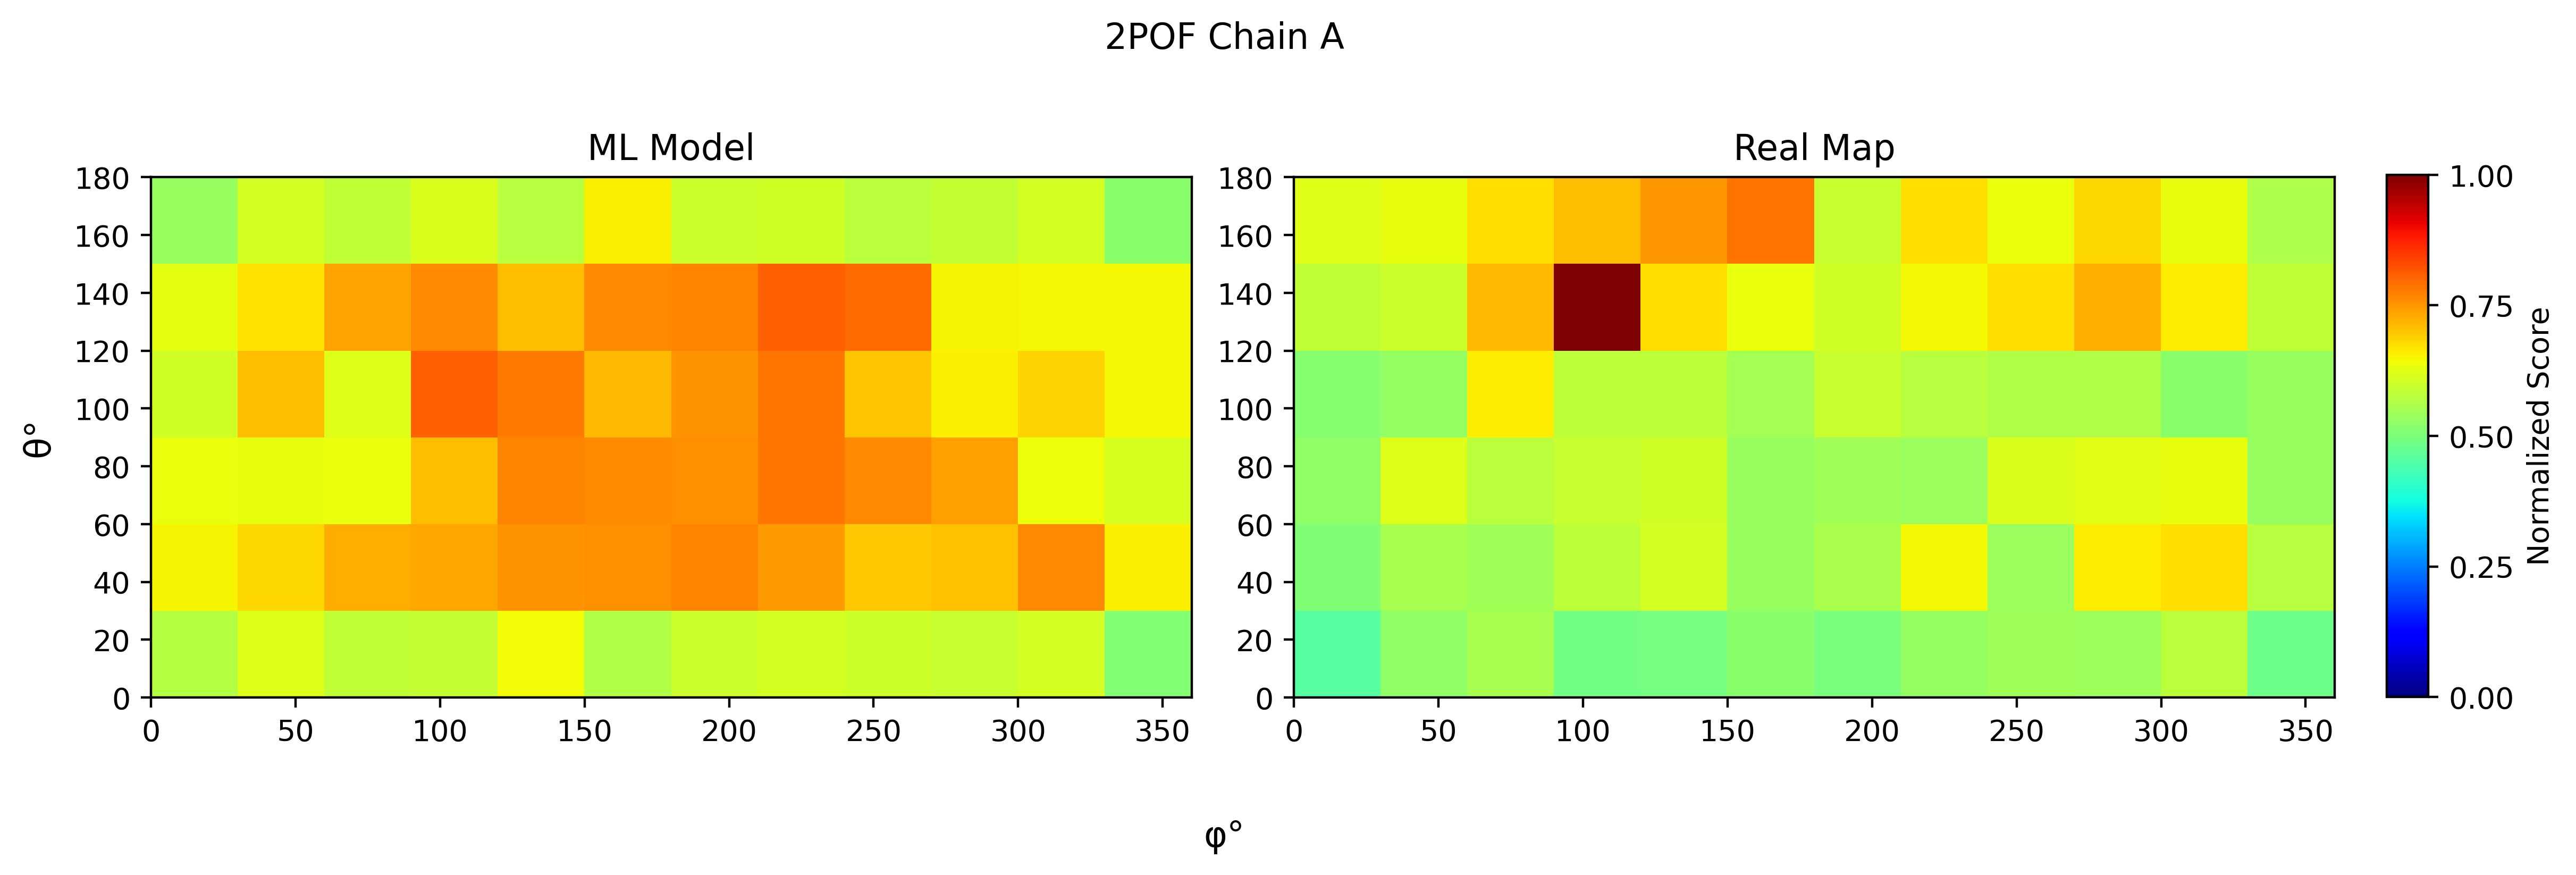

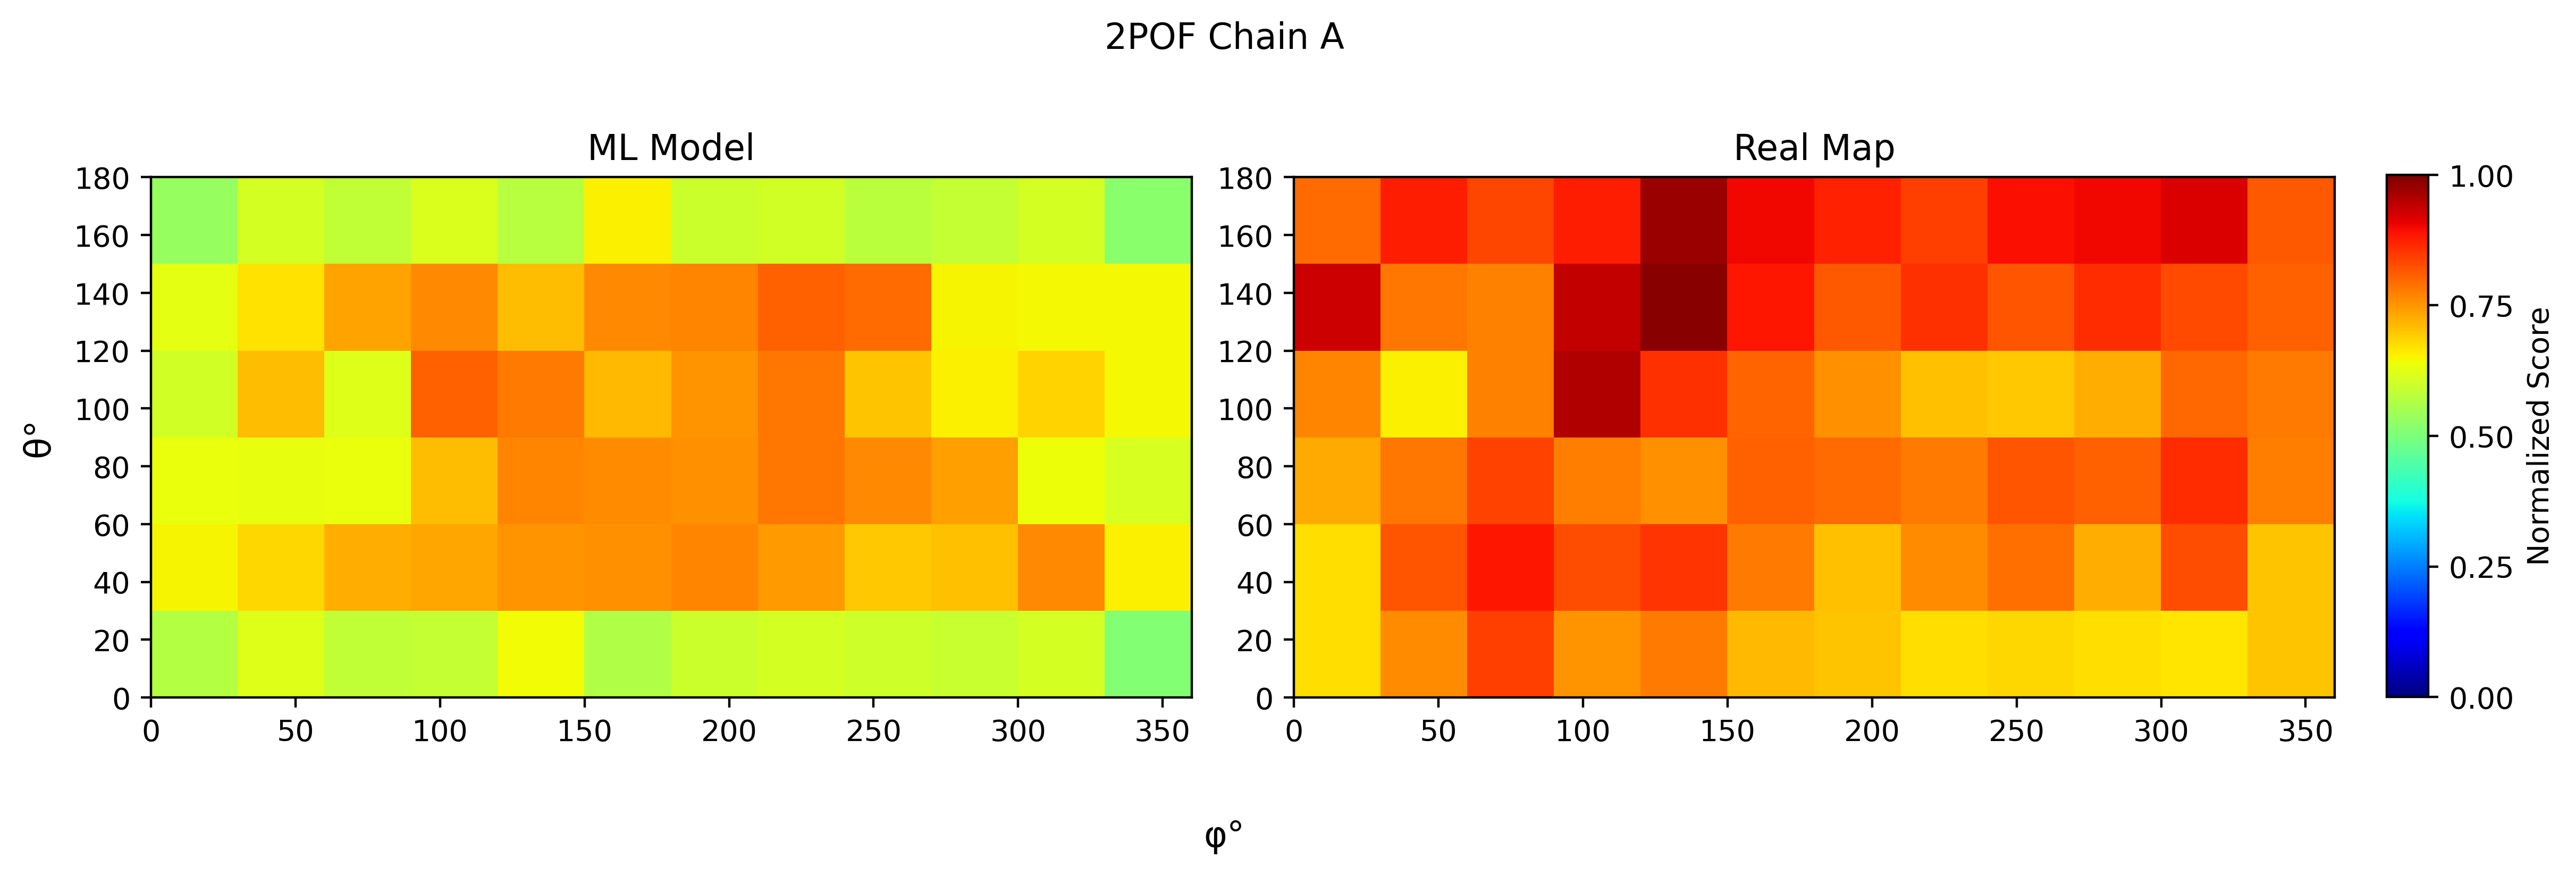

In [17]:
name = "d1jg8d_"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
plt.savefig(f"{name}_ML_mse_large.png", dpi = 400)
plt.show()

name = "d3pmga4"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
plt.savefig(f"{name}_ML_mse_large.png", dpi = 400)
plt.show()

In [16]:
lr = [0.01]
n_epochs=5

for cur_lr in lr:
    print("\n")
    print(f"Testing learning rate {cur_lr} with 3 sigmoids.")

    model = simpleNet_3sig_large()
    model.double()
    model.to(device)

    loss_fn = js_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=cur_lr)

    training_loss = list()

    n_steps = len(train_loader)
    for epoch in range(n_epochs):
        for i, (pdbInp, realOut) in enumerate(train_loader):
            pdbInp = pdbInp.to(device)
            realOut = realOut.to(device)

            trainOut = model(pdbInp)
            loss = loss_fn(trainOut, realOut)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            if (i+1) % 490 == 0:
                print(f"Epoch: {epoch+1}/{n_epochs} ; Step {i+1}/{n_steps} ; Loss: {loss.item():.6f}")
        training_loss.append(loss.item())

    valRunLoss = 0
    for i, (pdbInp, realOut) in enumerate(valid_loader):
            pdbInp = pdbInp.to(device)
            realOut = realOut.to(device)

            validOut = model(pdbInp)
            curLoss = loss_fn(validOut, realOut)
            valRunLoss += curLoss

    avgVLoss = valRunLoss / len(valid_loader)
    print(f"The average validation loss is {avgVLoss:.6f}")
    print("\n")
print("Finished!")



Testing learning rate 0.01 with 3 sigmoids.
Epoch: 1/5 ; Step 490/490 ; Loss: 0.002849
Epoch: 2/5 ; Step 490/490 ; Loss: 0.002340
Epoch: 3/5 ; Step 490/490 ; Loss: 0.001855
Epoch: 4/5 ; Step 490/490 ; Loss: 0.003530
Epoch: 5/5 ; Step 490/490 ; Loss: 0.003392
The average validation loss is 0.004118


Finished!


In [17]:
testRunLoss = 0
for i, (pdbInp, realOut) in enumerate(test_loader):
        pdbInp = pdbInp.to(device)
        realOut = realOut.to(device)

        testOut = model(pdbInp)
        curLoss = loss_fn(testOut, realOut)
        testRunLoss += curLoss

avgTLoss = testRunLoss / len(test_loader)
print(f"The average MSE of the testing dataset is {avgTLoss}")

The average MSE of the testing dataset is 0.0030173841559652556


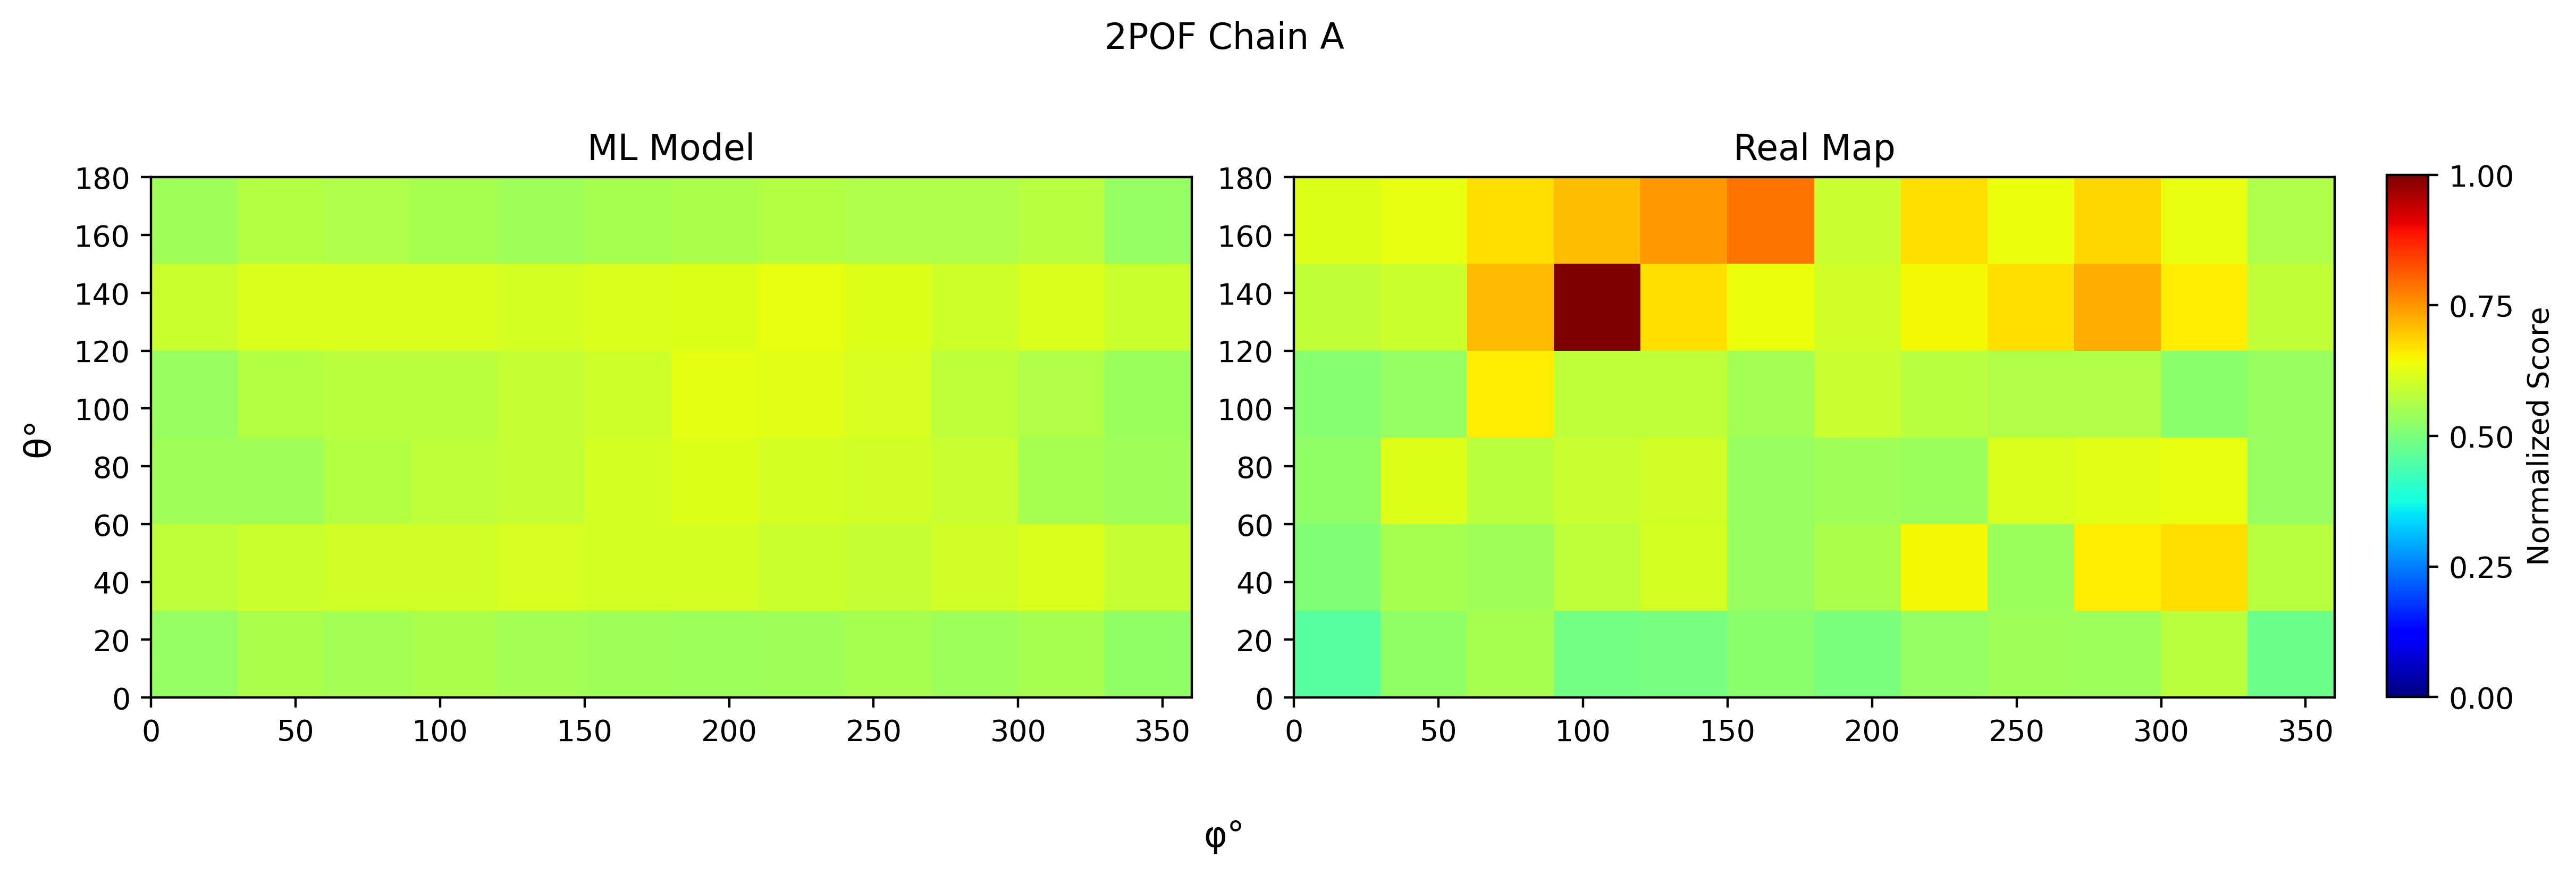

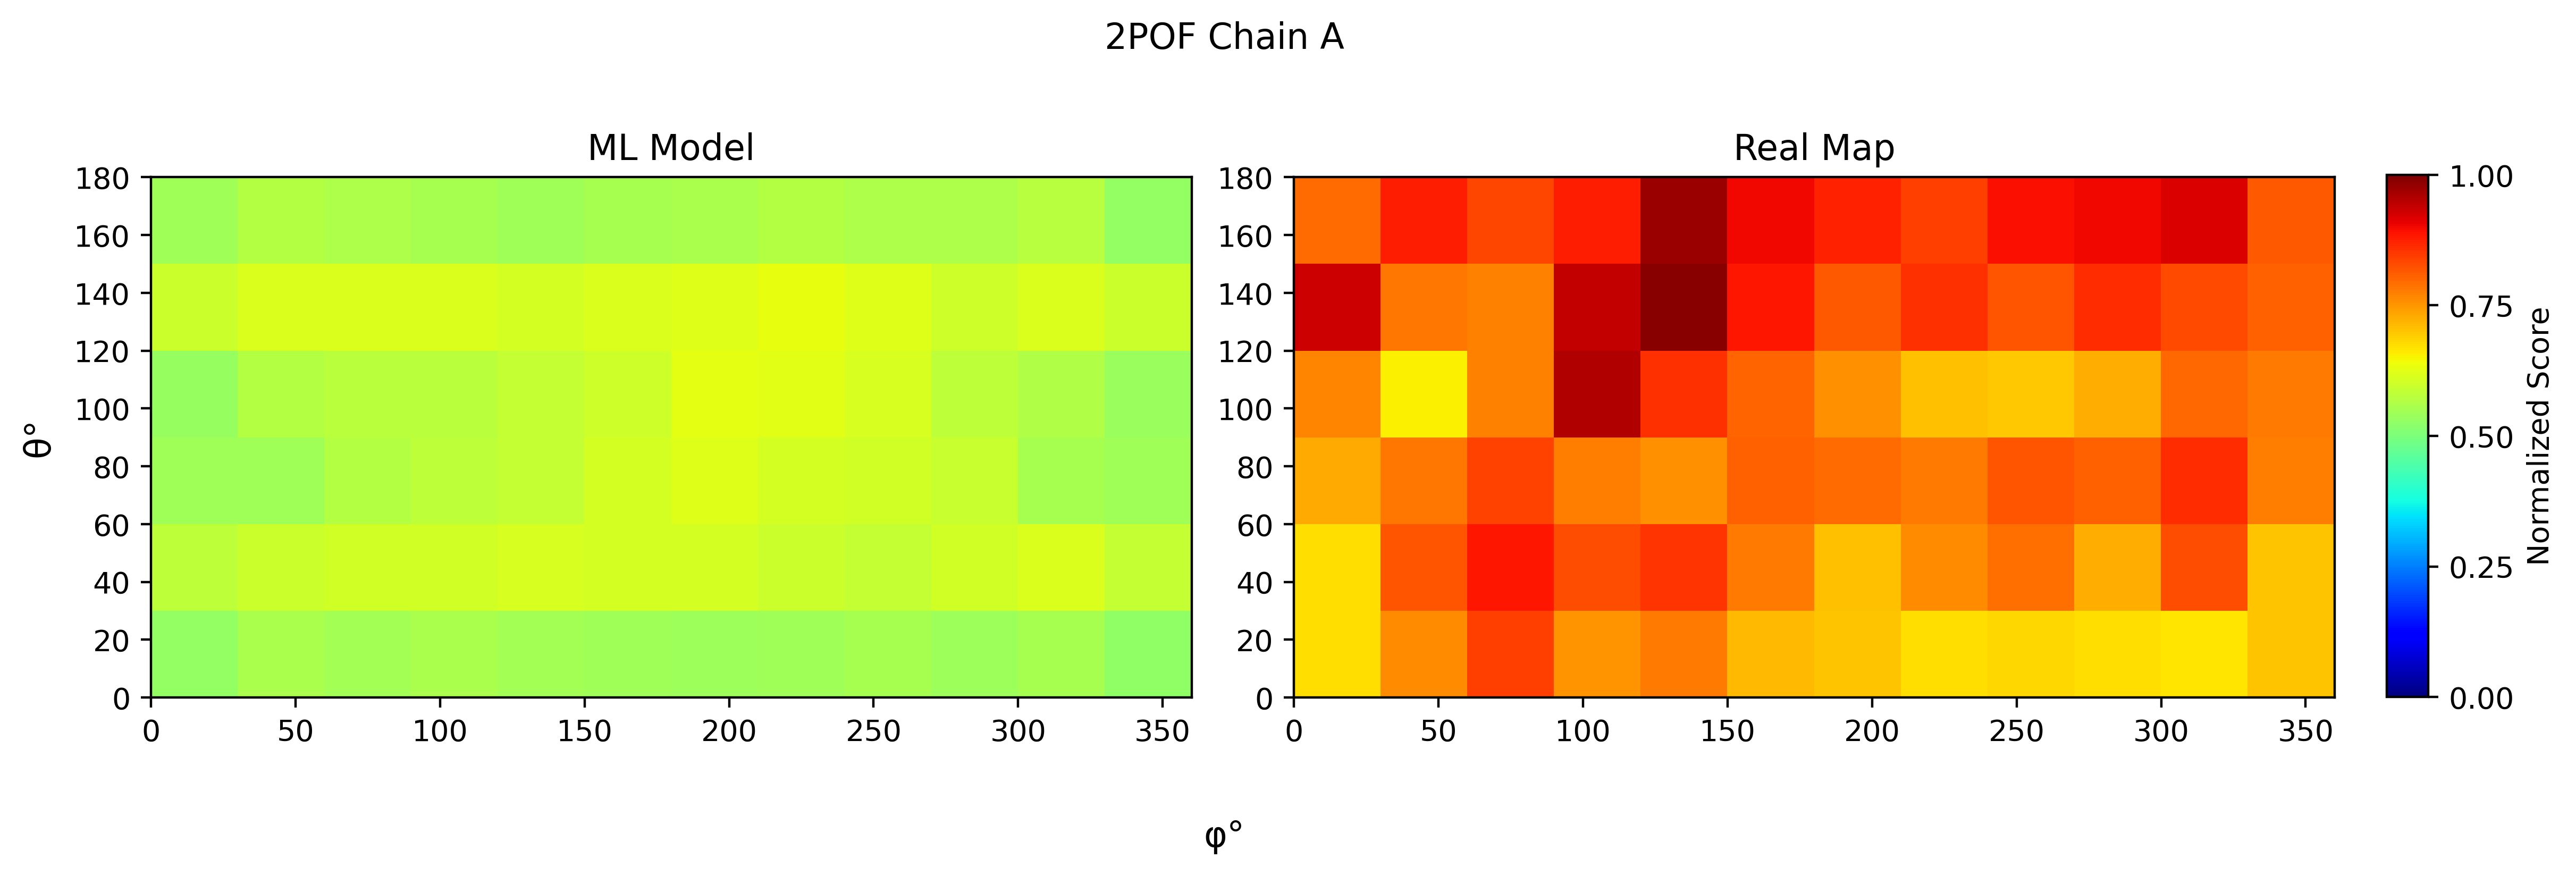

In [18]:
name = "d1jg8d_"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
plt.savefig(f"{name}_ML_js_large.png", dpi = 400)
plt.show()

name = "d3pmga4"

pdbInp = torch.load(f"testInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
realOut = torch.load(f"testOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
plt.savefig(f"{name}_ML_js_large.png", dpi = 400)
plt.show()

tensor([[[0.5294, 0.5572, 0.5482, 0.5564, 0.5503, 0.5452, 0.5399, 0.5456,
          0.5510, 0.5392, 0.5538, 0.5273],
         [0.5788, 0.5976, 0.6035, 0.6026, 0.6115, 0.6056, 0.6084, 0.5970,
          0.5882, 0.6048, 0.6153, 0.5881],
         [0.5443, 0.5465, 0.5675, 0.5783, 0.5864, 0.6055, 0.6211, 0.6079,
          0.6019, 0.5904, 0.5539, 0.5449],
         [0.5330, 0.5689, 0.5745, 0.5761, 0.5891, 0.6013, 0.6276, 0.6246,
          0.6110, 0.5815, 0.5663, 0.5353],
         [0.5960, 0.6147, 0.6155, 0.6141, 0.6087, 0.6135, 0.6206, 0.6316,
          0.6193, 0.6013, 0.6137, 0.5950],
         [0.5463, 0.5667, 0.5602, 0.5532, 0.5445, 0.5538, 0.5553, 0.5695,
          0.5615, 0.5621, 0.5710, 0.5307]]], device='cuda:0',
       dtype=torch.float64, grad_fn=<ViewBackward0>)


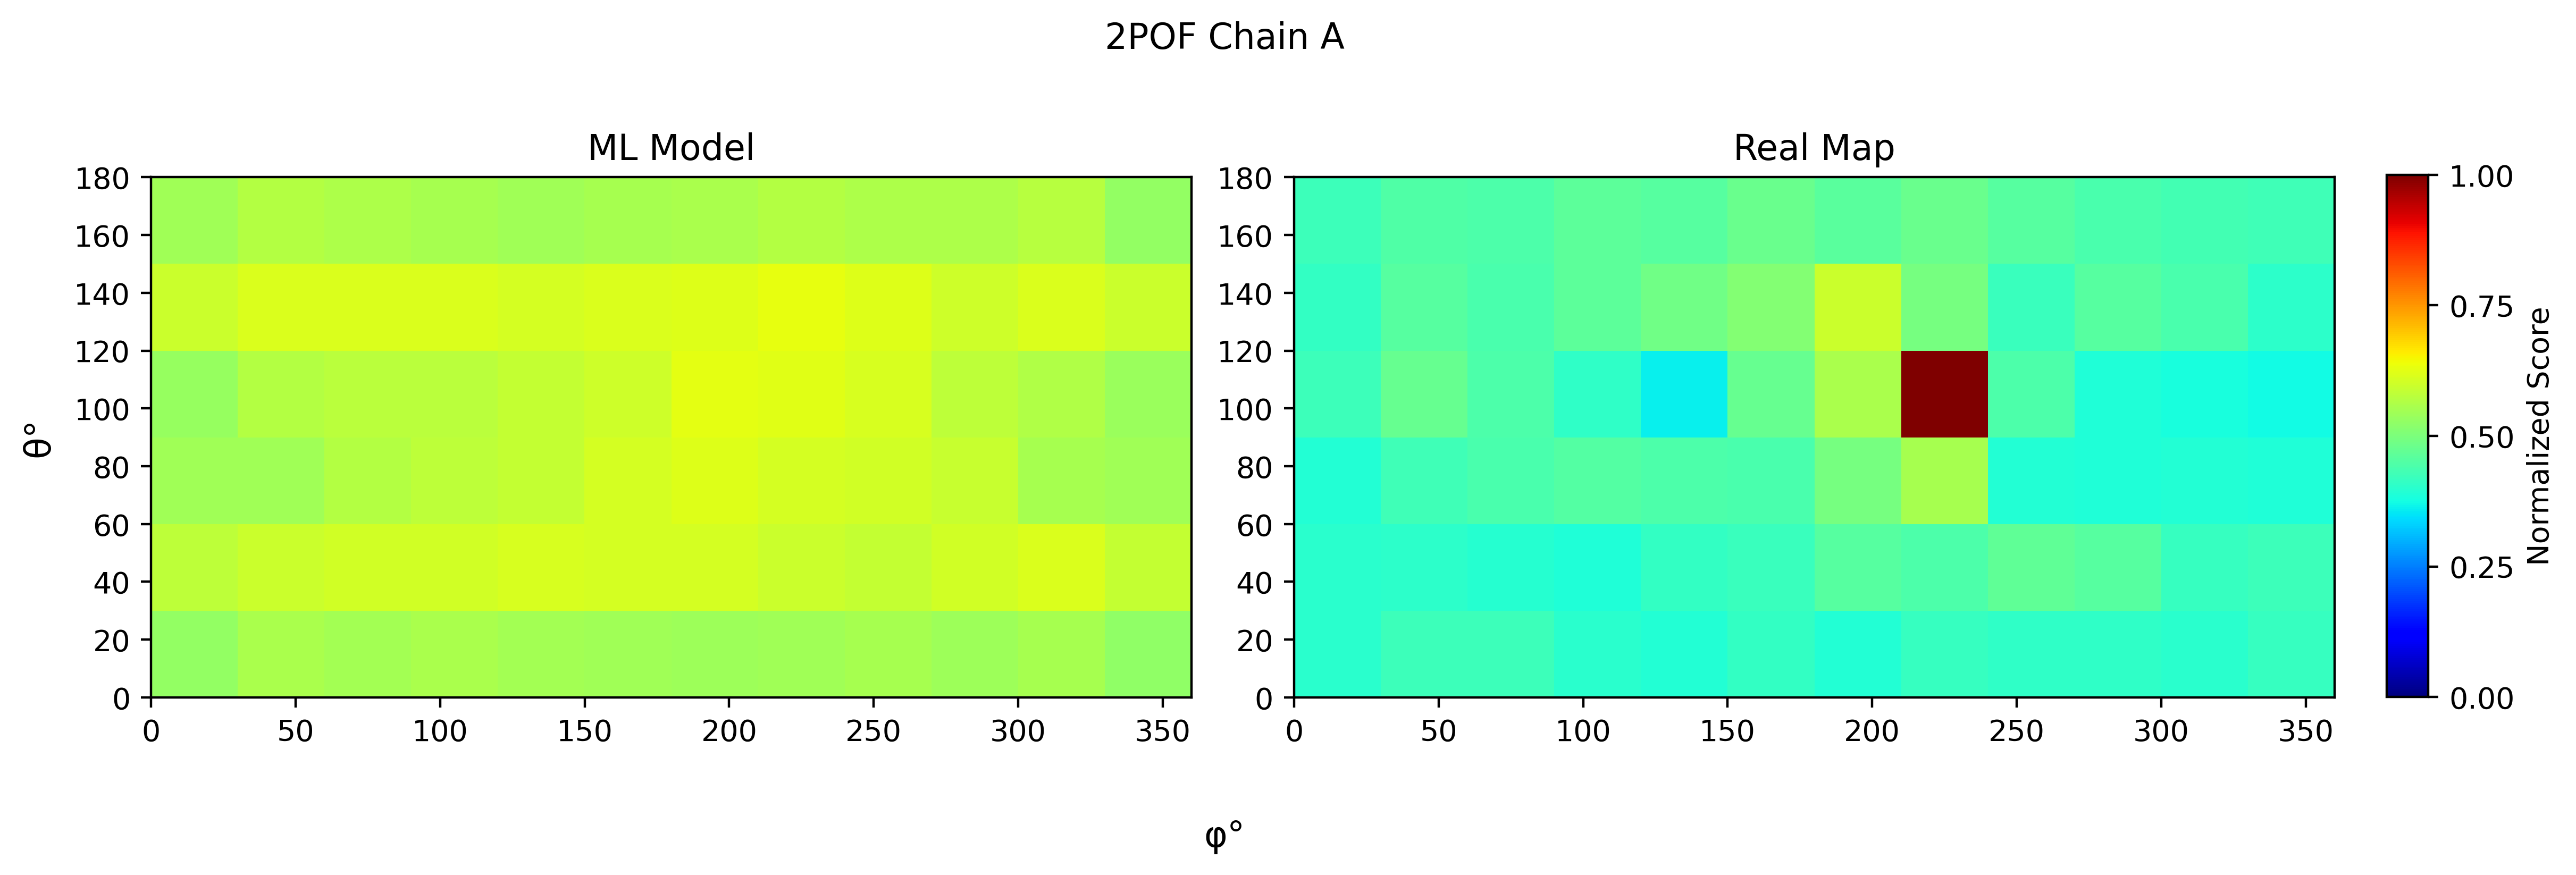

In [20]:
name = "d2pd1c_"

pdbInp = torch.load(f"trainInput/{name}.pt")
pdbInp = pdbInp.to(device)
testOut = model(pdbInp)
print(testOut)
realOut = torch.load(f"trainOutput/{name}_output.pt")

testOut = testOut.cpu()
testOut = torch.reshape(testOut, (6,12))
testOut = testOut.detach().numpy()
realOut = realOut.numpy()

ppi_map_model_compare(testOut, realOut, "2POF Chain A", "jet")
plt.show()